#  ĐỒ ÁN XỬ LÝ NGÔN NGỮ TỰ NHIÊN
## Đề tài: Dịch máy Anh - Pháp với mô hình Encoder-Decoder LSTM

---

###  Thông tin chung
* **Giảng viên hướng dẫn:** PGS.TS.Nguyễn Tuấn Đăng
* **Lớp:** DCT122C3

###  Nhóm sinh viên thực hiện:
1. **Họ và tên:** Huỳnh Minh Quân - **MSSV:** 3122411167
2. **Họ và tên:** Hồ Thái Vũ - **MSSV:** [Mã số SV 2]

---

###  Mục tiêu đồ án:
Xây dựng và huấn luyện một mô hình **Seq2Seq** sử dụng mạng nơ-ron **LSTM** (Long Short-Term Memory) để giải quyết bài toán dịch máy.
* **Input:** Chuỗi tiếng Anh (English).
* **Output:** Chuỗi tiếng Pháp (French).
* **Yêu cầu kỹ thuật:** Không sử dụng Attention, áp dụng kỹ thuật Padding & Packing, đánh giá bằng BLEU Score.
* **Công cụ:** Python, PyTorch, SpaCy.

## 1. Xử lý Dữ liệu (Data Preprocessing)

Bước này thực hiện các công việc quan trọng để chuẩn bị dữ liệu cho mô hình:

1.  **Load Data:** Đọc trực tiếp các file nén `.gz` (Train, Val, Test).
2.  **Tokenization:** Sử dụng thư viện `SpaCy` để tách câu thành các từ đơn (tokens).
3.  **Vocabulary:** Xây dựng bộ từ điển Anh và Pháp (giới hạn 10.000 từ phổ biến nhất).
4.  **DataLoader:**
    * Sử dụng kỹ thuật **Bucket Sorting** (sắp xếp câu theo độ dài) để tối ưu hóa.
    * Áp dụng **Padding** để đồng bộ độ dài các câu trong một Batch.

In [2]:
import torch
import spacy
import os
import re
import gzip
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# ======================================================
# 1. CẤU HÌNH ĐƯỜNG DẪN DỮ LIỆU
# ======================================================
def get_data_path():
    # 1. Xác định đường dẫn file code hiện tại
    try:
        current_file_path = os.path.abspath(__file__)
        current_dir = os.path.dirname(current_file_path)
    except NameError:
        current_dir = os.getcwd() # Fallback cho Jupyter Notebook

    # 2. Xác định thư mục gốc dự án (Project Root)
    project_root = os.path.dirname(current_dir) # .../Project
    
    # 3. Tạo đường dẫn đến tập dữ liệu
    # Cấu trúc: Project Root -> dataset -> raw
    data_path = os.path.join(project_root, 'dataset', 'raw')
    
    if os.path.exists(data_path):
        return data_path
    
    # Fallback: Tìm trong thư mục hiện tại
    local_path = os.path.join(current_dir, 'dataset', 'raw')
    if os.path.exists(local_path):
        return local_path

    return None

# --- THỰC THI ---
RAW_DIR = get_data_path()

if RAW_DIR:
    print(f"Đường dẫn dữ liệu: {RAW_DIR}")
    
    TRAIN_EN = os.path.join(RAW_DIR, 'train.en.gz')
    TRAIN_FR = os.path.join(RAW_DIR, 'train.fr.gz')
    VAL_EN = os.path.join(RAW_DIR, 'val.en.gz')
    VAL_FR = os.path.join(RAW_DIR, 'val.fr.gz')
    TEST_EN = os.path.join(RAW_DIR, 'test.en.gz')
    TEST_FR = os.path.join(RAW_DIR, 'test.fr.gz')
else:
    print("Lỗi: Không tìm thấy thư mục dữ liệu.")
    raise FileNotFoundError("Data not found")

# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ======================================================
# 2. TOKENIZER & CLEANER
# ======================================================
try:
    spacy_en = spacy.load('en_core_web_sm')
    spacy_fr = spacy.load('fr_core_news_sm')
except OSError:
    print("Tải thư viện Spacy...")
    os.system("python -m spacy download en_core_web_sm")
    os.system("python -m spacy download fr_core_news_sm")
    spacy_en = spacy.load('en_core_web_sm')
    spacy_fr = spacy.load('fr_core_news_sm')

def tokenize_en(text): return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_fr(text): return [tok.text for tok in spacy_fr.tokenizer(text)]

def clean_text(text: str) -> str:
    # Loại bỏ thẻ HTML, giữ khoảng trắng
    text = re.sub(r'<[^>]+>', ' ', text)
    # Chuẩn hóa khoảng trắng
    text = re.sub(r'\s+', ' ', text)
    # Xử lý khoảng trắng đầu/cuối và chuyển về chữ thường
    return text.strip().lower()


def open_file_smart(filepath):
    if filepath.endswith('.gz'):
        return gzip.open(filepath, 'rt', encoding='utf-8')
    return open(filepath, 'r', encoding='utf-8')

# ======================================================
# 3. VOCABULARY
# ======================================================
class Vocab:
    def __init__(self, freq_dict, specials=['<unk>', '<pad>', '<sos>', '<eos>'], max_tokens=10000):
        self.stoi = {s: i for i, s in enumerate(specials)}
        self.itos = {i: s for i, s in enumerate(specials)}
        self.unk_index = 0
        idx = len(specials)
        for word, _ in sorted(freq_dict.items(), key=lambda x: x[1], reverse=True):
            if idx >= max_tokens: break
            if word not in self.stoi:
                self.stoi[word] = idx; self.itos[idx] = word; idx += 1
    def __len__(self): return len(self.stoi)
    def __getitem__(self, token): return self.stoi.get(token, self.unk_index)

def build_vocab_custom(filepath, tokenizer):
    print(f"Xây dựng từ điển: {os.path.basename(filepath)}...")
    counter = Counter()
    if os.path.exists(filepath):
        with open_file_smart(filepath) as f:
            for line in f:
                t = clean_text(line)
                if t: counter.update(tokenizer(t))
    return Vocab(counter)

src_vocab = None
trg_vocab = None
SRC_PAD_IDX = 1
TRG_PAD_IDX = 1

if os.path.exists(TRAIN_EN):
    src_vocab = build_vocab_custom(TRAIN_EN, tokenize_en)
    trg_vocab = build_vocab_custom(TRAIN_FR, tokenize_fr)
    SRC_PAD_IDX = src_vocab['<pad>']
    TRG_PAD_IDX = trg_vocab['<pad>']
    print(f"Kích thước từ điển | EN: {len(src_vocab)} | FR: {len(trg_vocab)}")

# ======================================================
# 4. DATASET & DATALOADER
# ======================================================
class TranslationDataset(Dataset):
    def __init__(self, src_path, trg_path):
        self.data = []
        if os.path.exists(src_path) and os.path.exists(trg_path):
            print(f"Tải tập dữ liệu: {os.path.basename(src_path)}")
            with open_file_smart(src_path) as f_s, open_file_smart(trg_path) as f_t:
                srcs, trgs = f_s.readlines(), f_t.readlines()
                min_len = min(len(srcs), len(trgs))
                for i in range(min_len):
                    s, t = clean_text(srcs[i]), clean_text(trgs[i])
                    if s and t:
                        s_ts = torch.tensor([src_vocab['<sos>']] + [src_vocab[x] for x in tokenize_en(s)] + [src_vocab['<eos>']], dtype=torch.long)
                        t_ts = torch.tensor([trg_vocab['<sos>']] + [trg_vocab[x] for x in tokenize_fr(t)] + [trg_vocab['<eos>']], dtype=torch.long)
                        self.data.append((s_ts, t_ts))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    src_batch, trg_batch = [], []
    src_lens = []
    for src, trg in batch:
        src_batch.append(src)
        trg_batch.append(trg)
        src_lens.append(len(src))
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX)
    return src_batch, trg_batch, torch.tensor(src_lens)

BATCH_SIZE = 128
train_loader, val_loader, test_loader = None, None, None

if src_vocab:
    train_dataset = TranslationDataset(TRAIN_EN, TRAIN_FR)
    val_dataset = TranslationDataset(VAL_EN, VAL_FR)
    test_dataset = TranslationDataset(TEST_EN, TEST_FR)
    
    # Tối ưu: pin_memory=True tăng tốc độ chuyển dữ liệu lên GPU
    # num_workers=0: Tránh lỗi multiprocessing trên Windows
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, pin_memory=True)

# --- DEBUG ---
if __name__ == "__main__":
    if train_loader and len(train_loader) > 0:
        src, trg, lens = next(iter(train_loader))
        print(f"Kích thước Source: {src.shape}")
        print(f"Kích thước Target: {trg.shape}")

Đường dẫn dữ liệu: c:\Users\hmquaan\Downloads\SGU 2022-2027\Sem1 2025-2026\NLP\NLP_Project\dataset\raw
Xây dựng từ điển: train.en.gz...
Xây dựng từ điển: train.fr.gz...
Kích thước từ điển | EN: 9794 | FR: 10000
Tải tập dữ liệu: train.en.gz
Tải tập dữ liệu: val.en.gz
Tải tập dữ liệu: test.en.gz
Kích thước Source: torch.Size([24, 128])
Kích thước Target: torch.Size([28, 128])


C:\Users\hmquaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## 2. Xây dựng Mô hình (Seq2Seq Model)

Kiến trúc mô hình bao gồm 2 thành phần chính kết nối với nhau:

* **Encoder (Bộ mã hóa):**
    * Nhận câu tiếng Anh đầu vào.
    * Sử dụng lớp **Embedding** và **LSTM**.
    * Nén toàn bộ thông tin câu văn vào một *Context Vector* (Hidden State & Cell State).

* **Decoder (Bộ giải mã):**
    * Nhận *Context Vector* từ Encoder làm trạng thái khởi đầu.
    * Sinh ra từng từ tiếng Pháp tại mỗi bước thời gian.

> **Kỹ thuật nâng cao:** Sử dụng `pack_padded_sequence` để bỏ qua các token đệm vô nghĩa, giúp tăng tốc độ tính toán.

In [3]:
import torch.nn as nn
import random
from torch.nn.utils.rnn import pack_padded_sequence

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # Cấu hình: bidirectional=True
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        # src: [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        
        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=True)
        
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)
        
        # hidden: [n_layers * num_directions, batch size, hid dim]
        # cell: [n_layers * num_directions, batch size, hid dim]
        
        # Chuyển đổi trạng thái Bidirectional sang Unidirectional cho Decoder
        # Tổng hợp trạng thái chiều thuận và nghịch
        
        # Reshape để tách chiều directions
        # [n_layers, num_directions, batch, hid]
        hidden = hidden.view(self.n_layers, 2, -1, self.hid_dim)
        cell = cell.view(self.n_layers, 2, -1, self.hid_dim)
        
        # Tổng hợp 2 chiều (dim=1) -> [n_layers, batch, hid]
        hidden = hidden.sum(dim=1)
        cell = cell.sum(dim=1)
        
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src, src_len)
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 3. Huấn luyện Mô hình (Training)

Quá trình huấn luyện sử dụng các tham số (Hyperparameters) sau:

| Tham số | Giá trị | Ghi chú |
| :--- | :--- | :--- |
| **Optimizer** | Adam | Learning Rate = 0.001 |
| **Loss Function** | CrossEntropyLoss | Bỏ qua padding index |
| **Epochs** | 15 | Số vòng lặp huấn luyện |
| **Batch Size** | 128 | Kích thước lô dữ liệu |

* **Teacher Forcing:** Tỷ lệ 0.5 (50% cơ hội dùng nhãn thật để sửa lỗi cho Decoder).
* **Early Stopping:** Tự động dừng nếu Validation Loss không giảm sau 3 epochs.
* **Checkpoint:** Tự động lưu lại mô hình tốt nhất (`best_model.pth`).

In [3]:
import torch.optim as optim
import math
import time
import os
from tqdm import tqdm

# ==========================================
# 1. CẤU HÌNH THAM SỐ & KHỞI TẠO
# ==========================================
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 15
CLIP = 1
PATIENCE = 3  # Tham số dừng sớm

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# Hàm tính Accuracy
def calculate_accuracy(y_pred, y_true, pad_idx):
    _, max_idx = torch.max(y_pred, dim=1)
    correct = max_idx == y_true
    mask = y_true != pad_idx
    correct = correct & mask
    return correct.sum() / mask.sum()

#2. HÀM TRAIN & EVALUATE
# ==========================================
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    # Thanh tiến trình
    pbar = tqdm(iterator, desc='Training', leave=False)
    
    for i, (src, trg, src_len) in enumerate(pbar):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        acc = calculate_accuracy(output, trg, TRG_PAD_IDX)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{acc.item():.2%}'})
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    pbar = tqdm(iterator, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(pbar):
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_len, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg, TRG_PAD_IDX)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [6]:
# ==========================================
# 1. KHỞI TẠO MODEL
# ==========================================
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

# Khởi tạo trọng số
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# ==========================================
# 2. TRAINING LOOP (BASE MODEL)
# ==========================================
print(f"--- Bắt đầu huấn luyện Base Model (Device: {device}) ---")

history_file = 'models/training_history.json'
# Ghi nhận Accuracy cho biểu đồ, sử dụng Loss cho Early Stopping
history = {'train_loss': [], 'val_loss': [], 'train_ppl': [], 'val_ppl': [], 'train_acc': [], 'val_acc': []}

# Cấu hình Early Stopping dựa trên Loss
best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Lưu history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['train_ppl'].append(math.exp(train_loss))
    history['val_ppl'].append(math.exp(valid_loss))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(valid_acc)
    
    with open(history_file, 'w') as f:
        import json
        json.dump(history, f)

    # --- LOGIC EARLY STOPPING (LOSS) ---
    if valid_loss < best_valid_loss:
        old_best = best_valid_loss
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/best_model.pth')
        saved_msg = f"Lưu Model Tốt Nhất (Loss: {valid_loss:.4f} < {old_best:.4f})"
        patience_counter = 0
    else:
        patience_counter += 1
        saved_msg = f"Không Cải Thiện (Loss: {valid_loss:.4f} >= Best: {best_valid_loss:.4f}) | Đếm: {patience_counter}/{PATIENCE}"
    
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {epoch_mins}m {epoch_secs}s | {saved_msg}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    if patience_counter >= PATIENCE:
        print(f"\nDừng sớm: Kích hoạt (Sau {PATIENCE} epochs không cải thiện).")
        break

print(f"Lưu lịch sử huấn luyện: {history_file}")
print(f"Lưu model tốt nhất: models/best_model.pth")

--- Bắt đầu huấn luyện Base Model (Device: cpu) ---


Epoch: 01/15 | Time: 21m 54s | Lưu Model Tốt Nhất (Loss: 4.8605 < inf)
	Train Loss: 5.059 | Train PPL: 157.406 | Train Acc: 18.70%
	 Val. Loss: 4.860 |  Val. PPL: 129.085 |  Val. Acc: 18.33%


Epoch: 02/15 | Time: 20m 9s | Lưu Model Tốt Nhất (Loss: 4.4317 < 4.8605)
	Train Loss: 4.183 | Train PPL:  65.563 | Train Acc: 28.05%
	 Val. Loss: 4.432 |  Val. PPL:  84.076 |  Val. Acc: 23.35%


Epoch: 03/15 | Time: 19m 17s | Lưu Model Tốt Nhất (Loss: 4.2526 < 4.4317)
	Train Loss: 3.745 | Train PPL:  42.326 | Train Acc: 33.24%
	 Val. Loss: 4.253 |  Val. PPL:  70.290 |  Val. Acc: 26.81%


Epoch: 04/15 | Time: 16m 53s | Lưu Model Tốt Nhất (Loss: 4.0698 < 4.2526)
	Train Loss: 3.434 | Train PPL:  31.002 | Train Acc: 37.22%
	 Val. Loss: 4.070 |  Val. PPL:  58.543 |  Val. Acc: 28.52%


Epoch: 05/15 | Time: 15m 20s | Lưu Model Tốt Nhất (Loss: 3.9086 < 4.0698)
	Train Loss: 3.148 | Train PPL:  23.287 | Train Acc: 40.75%
	 Val. Loss: 3.909 |  Val. PPL:  49.831 |  Val. Acc: 30.39%


Epoch: 06/15 | Time: 11m 39s | Lưu Model Tốt Nhất (Loss: 3.7505 < 3.9086)
	Train Loss: 2.946 | Train PPL:  19.027 | Train Acc: 43.31%
	 Val. Loss: 3.750 |  Val. PPL:  42.541 |  Val. Acc: 32.65%


Epoch: 07/15 | Time: 12m 4s | Lưu Model Tốt Nhất (Loss: 3.7135 < 3.7505)
	Train Loss: 2.726 | Train PPL:  15.268 | Train Acc: 46.25%
	 Val. Loss: 3.713 |  Val. PPL:  40.996 |  Val. Acc: 33.96%


Epoch: 08/15 | Time: 11m 59s | Lưu Model Tốt Nhất (Loss: 3.5479 < 3.7135)
	Train Loss: 2.554 | Train PPL:  12.861 | Train Acc: 48.41%
	 Val. Loss: 3.548 |  Val. PPL:  34.739 |  Val. Acc: 35.73%


Epoch: 09/15 | Time: 12m 4s | Lưu Model Tốt Nhất (Loss: 3.5337 < 3.5479)
	Train Loss: 2.389 | Train PPL:  10.904 | Train Acc: 50.61%
	 Val. Loss: 3.534 |  Val. PPL:  34.250 |  Val. Acc: 36.21%


Epoch: 10/15 | Time: 11m 34s | Không Cải Thiện (Loss: 3.5711 >= Best: 3.5337) | Đếm: 1/3
	Train Loss: 2.229 | Train PPL:   9.294 | Train Acc: 52.92%
	 Val. Loss: 3.571 |  Val. PPL:  35.557 |  Val. Acc: 36.65%


Epoch: 11/15 | Time: 12m 5s | Lưu Model Tốt Nhất (Loss: 3.4957 < 3.5337)
	Train Loss: 2.117 | Train PPL:   8.304 | Train Acc: 54.47%
	 Val. Loss: 3.496 |  Val. PPL:  32.972 |  Val. Acc: 37.58%


Epoch: 12/15 | Time: 12m 0s | Lưu Model Tốt Nhất (Loss: 3.4017 < 3.4957)
	Train Loss: 2.001 | Train PPL:   7.397 | Train Acc: 56.31%
	 Val. Loss: 3.402 |  Val. PPL:  30.014 |  Val. Acc: 38.71%


Epoch: 13/15 | Time: 11m 44s | Lưu Model Tốt Nhất (Loss: 3.3585 < 3.4017)
	Train Loss: 1.879 | Train PPL:   6.544 | Train Acc: 58.21%
	 Val. Loss: 3.359 |  Val. PPL:  28.746 |  Val. Acc: 40.03%


Epoch: 14/15 | Time: 11m 50s | Không Cải Thiện (Loss: 3.4800 >= Best: 3.3585) | Đếm: 1/3
	Train Loss: 1.755 | Train PPL:   5.781 | Train Acc: 60.38%
	 Val. Loss: 3.480 |  Val. PPL:  32.460 |  Val. Acc: 39.19%


Epoch: 15/15 | Time: 12m 0s | Không Cải Thiện (Loss: 3.4438 >= Best: 3.3585) | Đếm: 2/3
	Train Loss: 1.675 | Train PPL:   5.338 | Train Acc: 61.84%
	 Val. Loss: 3.444 |  Val. PPL:  31.305 |  Val. Acc: 39.89%
Lưu lịch sử huấn luyện: models/training_history.json
Lưu model tốt nhất: models/best_model.pth


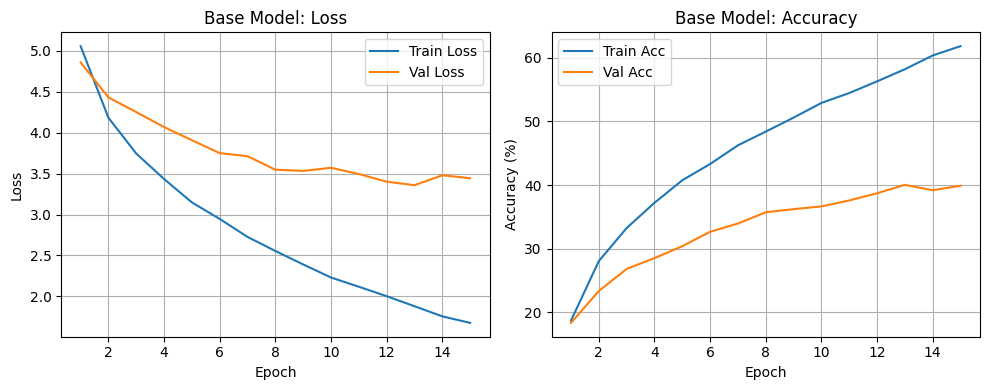

Lưu biểu đồ: models/training_chart_base.png


In [4]:
import matplotlib.pyplot as plt
import json

# ==========================================
# VẼ BIỂU ĐỒ (BASE MODEL)
# ==========================================
history_file = 'models/training_history.json'

try:
    with open(history_file, 'r') as hf:
        history = json.load(hf)

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 4))

    # 1. Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Base Model: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    if 'train_acc' in history:
        plt.plot(epochs, [acc * 100 for acc in history['train_acc']], label='Train Acc')
        plt.plot(epochs, [acc * 100 for acc in history['val_acc']], label='Val Acc')
        plt.ylabel('Accuracy (%)')
        plt.title('Base Model: Accuracy')
    else:
        plt.plot(epochs, history['train_ppl'], label='Train PPL')
        plt.plot(epochs, history['val_ppl'], label='Val PPL')
        plt.ylabel('Perplexity')
        plt.title('Base Model: Perplexity')

    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('models/training_chart_base.png')
    plt.show()
    print("Lưu biểu đồ: models/training_chart_base.png")

except FileNotFoundError:
    print("Chưa tìm thấy file lịch sử huấn luyện.")

## 4. Dự đoán & Đánh giá (Inference & Evaluation)

Giai đoạn kiểm thử mô hình sau khi huấn luyện xong:

1.  **Dịch thử (Demo):** Chạy mô hình trên 5 câu tiếng Anh mẫu để kiểm tra ngữ nghĩa trực quan.
2.  **Tính điểm BLEU:**
    * Sử dụng thư viện `nltk.translate.bleu_score`.
    * Đánh giá độ chính xác của bản dịch máy so với bản dịch gốc trên toàn bộ tập **Test**.
    * **Yêu cầu:** BLEU Score > 15.0.

In [15]:
import torch
import torch.nn as nn
import random
import math
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm # Sử dụng phiên bản chuẩn
import os

# ==========================================
# 1. TẢI MÔ HÌNH
# ==========================================
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

# Tải model tốt nhất
model_path = 'models/best_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Tải model từ: {model_path}")
else:
    print(f"Lỗi: Không tìm thấy file model tại {model_path}")

model.eval()

# ==========================================
# 1.1 HÀM HỖ TRỢ ĐÁNH GIÁ (EVALUATE)
# ==========================================
# Định nghĩa lại hàm evaluate để đảm bảo chạy độc lập
def calculate_accuracy(y_pred, y_true, pad_idx):
    _, max_idx = torch.max(y_pred, dim=1)
    correct = max_idx == y_true
    mask = y_true != pad_idx
    correct = correct & mask
    return correct.sum() / mask.sum()

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    pbar = tqdm(iterator, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(pbar):
            src, trg = src.to(device), trg.to(device)
            # 0 = turn off teacher forcing
            output = model(src, src_len, trg, 0) 
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg, TRG_PAD_IDX)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# ==========================================
# 2. HÀM DỊCH
# ==========================================
def translate(sentence: str, max_len=50) -> str:
    model.eval()
    if isinstance(sentence, str): tokens = [t.lower() for t in tokenize_en(sentence)]
    else: tokens = [t.lower() for t in sentence]
    
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_len)
    
    trg_indexes = [trg_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab['<eos>']: break
        
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return " ".join(trg_tokens[1:-1] if trg_tokens[-1] == '<eos>' else trg_tokens[1:])

# ==========================================
# 3. LẤY RANDOM TỪ TẬP TEST
# ==========================================
def show_random_examples(num_examples=5):
    print("\n" + "="*60)
    print(f"--- Kiểm tra dịch ngẫu nhiên ({num_examples} câu) ---")
    print("="*60)
    
    with open_file_smart(TEST_EN) as f_en, open_file_smart(TEST_FR) as f_fr:
        en_lines = f_en.readlines()
        fr_lines = f_fr.readlines()
    
    indices = random.sample(range(len(en_lines)), num_examples)
    
    for idx in indices:
        src = clean_text(en_lines[idx])
        trg = clean_text(fr_lines[idx])
        pred = translate(src)
        
        print(f"Src:  {src}")
        print(f"Ref:  {trg}")
        print(f"Pred: {pred}")
        print("-" * 60)

# ==========================================
# 4. HÀM TÍNH BLEU
# ==========================================
def calculate_bleu(data_loader, model, device):
    model.eval()
    trgs = []
    pred_trgs = []
    
    # --- THANH CHẠY GIỐNG PHẦN TRAIN ---
    pbar = tqdm(data_loader, desc='Calculating BLEU', leave=False)
    
    with torch.no_grad():
        for src, trg, src_len in pbar:
            src = src.to(device)
            
            for i in range(src.shape[1]):
                # Trích xuất câu nguồn (loại bỏ padding)
                src_idxs = [x.item() for x in src[:, i] if x != src_vocab['<pad>']]
                src_tokens = [src_vocab.itos[x] for x in src_idxs][1:-1]
                
                # Dịch
                pred_tokens = translate(" ".join(src_tokens)).split()
                pred_trgs.append(pred_tokens)
                
                # Trích xuất câu đích (loại bỏ padding)
                trg_idxs = [x.item() for x in trg[:, i] if x != trg_vocab['<pad>']]
                trg_tokens = [trg_vocab.itos[x] for x in trg_idxs][1:-1]
                trgs.append([trg_tokens])

    return corpus_bleu(trgs, pred_trgs)

# ==========================================
# 5. DỰ ĐOÁN VÀ TÍNH BLEU & ACCURACY
# ==========================================
if __name__ == "__main__":
    # 1. Hiển thị 5 ví dụ ngẫu nhiên
    show_random_examples(5)

    # 2. Tính BLEU & Accuracy
    print("\nĐánh giá trên tập Test...")
    if 'test_loader' in globals() and test_loader is not None:
        # Tính BLEU
        score = calculate_bleu(test_loader, model, device)
        print(f'BLEU Score = {score*100:.2f}')
        
        # Tính Accuracy
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Test Acc: {test_acc*100:.2f}%')
    else:
        print("Lỗi: Dữ liệu Test không tồn tại.")

Tải model từ: models/best_model.pth

--- Kiểm tra dịch ngẫu nhiên (5 câu) ---
Src:  a young boy jumping from a bunk bed on a smaller bed.
Ref:  un jeune garçon sautant d'un lit superposé sur un lit plus petit.
Pred: un jeune garçon sautant d' un poteau à à un poteau en pleurs .
------------------------------------------------------------
Src:  two women are strapped to a tree in some type of construction job.
Ref:  deux femmes exerçant une sorte de métier de construction sont attachées à un arbre.
Pred: deux femmes posent à une d' un grand bâtiment de de . .
------------------------------------------------------------
Src:  two men pretend to be statutes while women look on.
Ref:  deux hommes font semblant d'être des statues, tandis que des femmes regardent.
Pred: deux hommes s' occupent à prendre des autres d' autres . .
------------------------------------------------------------
Src:  woman in a pink shirt and wearing glasses.
Ref:  une femme avec une chemise rose et des lunettes.
P

BLEU Score = 30.64


Test Loss: 3.234 | Test PPL:  25.380 | Test Acc: 40.94%


## 5. Nâng cao: Mô hình Seq2Seq với Attention

Cơ chế **Attention (Bahdanau)** được tích hợp để cải thiện hiệu suất, đặc biệt đối với các câu dài.

*   **Cải tiến:** Decoder không chỉ dựa vào Context Vector tĩnh mà sẽ "nhìn" (attend) vào toàn bộ trạng thái của Encoder tại mỗi bước giải mã.
*   **Kiến trúc:**
    *   **Encoder:** Bidirectional LSTM (trả về cả `outputs` để tính attention).
    *   **Attention Layer:** Tính toán trọng số quan trọng của từng từ nguồn.
    *   **Decoder:** Kết hợp Embedding của từ hiện tại + Context Vector từ Attention.

In [16]:
import torch.nn.functional as F

# 1. ENCODER (Trả về outputs)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed_embedded = pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=True)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)
        
        # Unpack outputs cho Attention
        # outputs: [src len, batch size, hid dim * 2]
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        # Xử lý hidden/cell cho Decoder (Tổng hợp 2 chiều)
        hidden = hidden.view(self.n_layers, 2, -1, self.hid_dim)
        cell = cell.view(self.n_layers, 2, -1, self.hid_dim)
        hidden = hidden.sum(dim=1)
        cell = cell.sum(dim=1)
        
        return outputs, hidden, cell

# 2. ATTENTION LAYER
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden: [batch size, dec hid dim] (Layer cuối của decoder)
        # encoder_outputs: [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # Lặp lại hidden state để khớp kích thước
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # Tính energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        
        # Tính attention scores
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

# 3. DECODER WITH ATTENTION
class DecoderAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.attention = Attention(enc_hid_dim, dec_hid_dim)
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        
        # Tính trọng số attention (sử dụng hidden state lớp cuối)
        # hidden[-1]: [batch, hid_dim]
        a = self.attention(hidden[-1], encoder_outputs)
        a = a.unsqueeze(1)
        
        # Tính weighted source vector
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        
        # Input cho RNN: [embedded; weighted]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        
        # Prediction: [output; weighted; embedded]
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden, cell

# 4. SEQ2SEQ WITH ATTENTION
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Encoder trả về encoder_outputs
        encoder_outputs, hidden, cell = self.encoder(src, src_len)
        
        input = trg[0, :]
        for t in range(1, trg_len):
            # Decoder nhận encoder_outputs
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 6. Huấn luyện (Attention)

Huấn luyện mô hình Attention với cấu hình tương tự để so sánh.
*   **File lưu:** `models/best_model_attn.pth`
*   **Lịch sử:** `models/history_attn.json`


In [10]:
# ==========================================
# 1. KHỞI TẠO MODEL ATTENTION
# ==========================================
attn_enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attn_dec = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_attn = Seq2SeqAttention(attn_enc, attn_dec, device).to(device)
model_attn.apply(init_weights)

optimizer_attn = optim.Adam(model_attn.parameters(), lr=LEARNING_RATE)

# ==========================================
# 2. TRAINING LOOP (ATTENTION)
# ==========================================
print(f"\n--- Bắt đầu huấn luyện Attention Model (Device: {device}) ---")

history_attn_file = 'models/history_attn.json'
history_attn = {'train_loss': [], 'val_loss': [], 'train_ppl': [], 'val_ppl': [], 'train_acc': [], 'val_acc': []}

# Cấu hình Early Stopping dựa trên Loss
best_valid_loss_attn = float('inf')
patience_counter = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model_attn, train_loader, optimizer_attn, criterion, CLIP)
    valid_loss, valid_acc = evaluate(model_attn, val_loader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    history_attn['train_loss'].append(train_loss)
    history_attn['val_loss'].append(valid_loss)
    history_attn['train_ppl'].append(math.exp(train_loss))
    history_attn['val_ppl'].append(math.exp(valid_loss))
    history_attn['train_acc'].append(train_acc)
    history_attn['val_acc'].append(valid_acc)
    
    with open(history_attn_file, 'w') as hf:
        import json
        json.dump(history_attn, hf)

    # --- LOGIC EARLY STOPPING (LOSS) ---
    if valid_loss < best_valid_loss_attn:
        old_best = best_valid_loss_attn
        best_valid_loss_attn = valid_loss
        torch.save(model_attn.state_dict(), 'models/best_model_attn.pth')
        saved_msg = f"Lưu Model Tốt Nhất (Loss: {valid_loss:.4f} < {old_best:.4f})"
        patience_counter = 0
    else:
        patience_counter += 1
        saved_msg = f"Không Cải Thiện (Loss: {valid_loss:.4f} >= Best: {best_valid_loss_attn:.4f}) | Đếm: {patience_counter}/{PATIENCE}"
    
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {epoch_mins}m {epoch_secs}s | {saved_msg}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    if patience_counter >= PATIENCE:
        print(f"\nDừng sớm: Kích hoạt (Sau {PATIENCE} epochs không cải thiện).")
        break

print(f"Lưu lịch sử huấn luyện: {history_attn_file}")
print(f"Lưu model tốt nhất: models/best_model_attn.pth")


--- Bắt đầu huấn luyện Attention Model (Device: cpu) ---


Epoch: 01/15 | Time: 29m 53s | Lưu Model Tốt Nhất (Loss: 3.9188 < inf)
	Train Loss: 4.606 | Train PPL: 100.120 | Train Acc: 25.53%
	 Val. Loss: 3.919 |  Val. PPL:  50.338 |  Val. Acc: 30.80%


Epoch: 02/15 | Time: 29m 57s | Lưu Model Tốt Nhất (Loss: 3.2712 < 3.9188)
	Train Loss: 3.032 | Train PPL:  20.736 | Train Acc: 46.04%
	 Val. Loss: 3.271 |  Val. PPL:  26.344 |  Val. Acc: 39.44%


Epoch: 03/15 | Time: 30m 6s | Lưu Model Tốt Nhất (Loss: 3.0174 < 3.2712)
	Train Loss: 2.346 | Train PPL:  10.448 | Train Acc: 54.91%
	 Val. Loss: 3.017 |  Val. PPL:  20.438 |  Val. Acc: 44.21%


Epoch: 04/15 | Time: 29m 55s | Lưu Model Tốt Nhất (Loss: 2.9110 < 3.0174)
	Train Loss: 1.928 | Train PPL:   6.875 | Train Acc: 60.36%
	 Val. Loss: 2.911 |  Val. PPL:  18.375 |  Val. Acc: 46.39%


Epoch: 05/15 | Time: 29m 18s | Không Cải Thiện (Loss: 2.9180 >= Best: 2.9110) | Đếm: 1/3
	Train Loss: 1.600 | Train PPL:   4.954 | Train Acc: 65.13%
	 Val. Loss: 2.918 |  Val. PPL:  18.505 |  Val. Acc: 47.70%


Epoch: 06/15 | Time: 29m 5s | Không Cải Thiện (Loss: 2.9215 >= Best: 2.9110) | Đếm: 2/3
	Train Loss: 1.366 | Train PPL:   3.920 | Train Acc: 69.07%
	 Val. Loss: 2.921 |  Val. PPL:  18.569 |  Val. Acc: 48.00%


Epoch: 07/15 | Time: 26m 51s | Lưu Model Tốt Nhất (Loss: 2.9016 < 2.9110)
	Train Loss: 1.187 | Train PPL:   3.278 | Train Acc: 72.43%
	 Val. Loss: 2.902 |  Val. PPL:  18.204 |  Val. Acc: 48.28%


Epoch: 08/15 | Time: 28m 58s | Không Cải Thiện (Loss: 3.0087 >= Best: 2.9016) | Đếm: 1/3
	Train Loss: 1.051 | Train PPL:   2.860 | Train Acc: 75.14%
	 Val. Loss: 3.009 |  Val. PPL:  20.261 |  Val. Acc: 48.40%


Epoch: 09/15 | Time: 29m 2s | Không Cải Thiện (Loss: 3.0356 >= Best: 2.9016) | Đếm: 2/3
	Train Loss: 0.945 | Train PPL:   2.573 | Train Acc: 77.30%
	 Val. Loss: 3.036 |  Val. PPL:  20.813 |  Val. Acc: 49.38%


Epoch: 10/15 | Time: 29m 6s | Không Cải Thiện (Loss: 2.9918 >= Best: 2.9016) | Đếm: 3/3
	Train Loss: 0.842 | Train PPL:   2.321 | Train Acc: 79.56%
	 Val. Loss: 2.992 |  Val. PPL:  19.922 |  Val. Acc: 50.28%

Dừng sớm: Kích hoạt (Sau 3 epochs không cải thiện).
Lưu lịch sử huấn luyện: models/history_attn.json
Lưu model tốt nhất: models/best_model_attn.pth


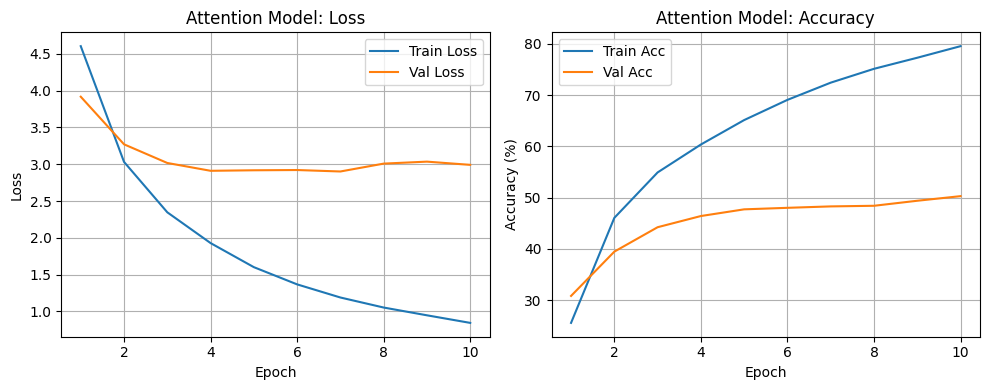

Lưu biểu đồ: models/training_chart_attn.png


In [17]:
import matplotlib.pyplot as plt
import json

# ==========================================
# VẼ BIỂU ĐỒ (ATTENTION MODEL)
# ==========================================
history_attn_file = 'models/history_attn.json'

try:
    with open(history_attn_file, 'r') as hf:
        history = json.load(hf)

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 4))

    # 1. Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Attention Model: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    if 'train_acc' in history:
        plt.plot(epochs, [acc * 100 for acc in history['train_acc']], label='Train Acc')
        plt.plot(epochs, [acc * 100 for acc in history['val_acc']], label='Val Acc')
        plt.ylabel('Accuracy (%)')
        plt.title('Attention Model: Accuracy')
    else:
        plt.plot(epochs, history['train_ppl'], label='Train PPL')
        plt.plot(epochs, history['val_ppl'], label='Val PPL')
        plt.ylabel('Perplexity')
        plt.title('Attention Model: Perplexity')

    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('models/training_chart_attn.png')
    plt.show()
    print("Lưu biểu đồ: models/training_chart_attn.png")

except FileNotFoundError:
    print("Chưa tìm thấy file lịch sử huấn luyện Attention.")

## 7. Dự đoán & Đánh giá (Attention Model)

Tương tự như Base Model, chúng ta sẽ kiểm tra kết quả dịch và tính điểm BLEU/Accuracy cho mô hình Attention.

In [20]:
# ==========================================
# 1. TẢI MÔ HÌNH ATTENTION
# ==========================================
import math
import os
import torch
import torch.nn as nn
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

# Định nghĩa lại tham số (đảm bảo giống lúc train)
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Khởi tạo kiến trúc model Attention
attn_enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attn_dec = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_attn = Seq2SeqAttention(attn_enc, attn_dec, device).to(device)

model_attn_path = 'models/best_model_attn.pth'
if os.path.exists(model_attn_path):
    model_attn.load_state_dict(torch.load(model_attn_path, map_location=device))
    print(f"Tải model Attention từ: {model_attn_path}")
else:
    print(f"Lỗi: Không tìm thấy file model tại {model_attn_path}")

model_attn.eval()

# ==========================================
# 1.1 HÀM HỖ TRỢ ĐÁNH GIÁ (EVALUATE)
# ==========================================
def calculate_accuracy(y_pred, y_true, pad_idx):
    _, max_idx = torch.max(y_pred, dim=1)
    correct = max_idx == y_true
    mask = y_true != pad_idx
    correct = correct & mask
    return correct.sum() / mask.sum()

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    pbar = tqdm(iterator, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(pbar):
            src, trg = src.to(device), trg.to(device)
            # 0 = turn off teacher forcing
            output = model(src, src_len, trg, 0) 
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg, TRG_PAD_IDX)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# ==========================================
# 2. HÀM DỊCH (ATTENTION)
# ==========================================
def translate_attn_func(sentence: str, max_len=50) -> str:
    model_attn.eval()
    if isinstance(sentence, str): tokens = [t.lower() for t in tokenize_en(sentence)]
    else: tokens = [t.lower() for t in sentence]
    
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = model_attn.encoder(src_tensor, src_len)
    
    trg_indexes = [trg_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model_attn.decoder(trg_tensor, hidden, cell, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab['<eos>']: break
        
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return " ".join(trg_tokens[1:-1] if trg_tokens[-1] == '<eos>' else trg_tokens[1:])

# ==========================================
# 3. LẤY RANDOM TỪ TẬP TEST (ATTENTION)
# ==========================================
def show_random_examples_attn(num_examples=5):
    print("\n" + "="*60)
    print(f"--- Kiểm tra dịch ngẫu nhiên (Attention Model) ---")
    print("="*60)
    
    with open_file_smart(TEST_EN) as f_en, open_file_smart(TEST_FR) as f_fr:
        en_lines = f_en.readlines()
        fr_lines = f_fr.readlines()
    
    indices = random.sample(range(len(en_lines)), num_examples)
    
    for idx in indices:
        src = clean_text(en_lines[idx])
        trg = clean_text(fr_lines[idx])
        pred = translate_attn_func(src)
        
        # Tính Sentence BLEU
        ref_tokens = [t.lower() for t in tokenize_fr(trg)]
        pred_tokens = pred.split()
        score = sentence_bleu([ref_tokens], pred_tokens)
        
        print(f"Src:  {src}")
        print(f"Ref:  {trg}")
        print(f"Pred: {pred}")
        print("-" * 60)

# ==========================================
# 4. HÀM TÍNH BLEU (ATTENTION)
# ==========================================
def calculate_bleu_attn(data_loader, device):
    model_attn.eval()
    trgs = []
    pred_trgs = []
    
    pbar = tqdm(data_loader, desc='Calculating BLEU (Attention)', leave=False)
    
    with torch.no_grad():
        for src, trg, src_len in pbar:
            src = src.to(device)
            
            for i in range(src.shape[1]):
                src_idxs = [x.item() for x in src[:, i] if x != src_vocab['<pad>']]
                src_tokens = [src_vocab.itos[x] for x in src_idxs][1:-1]
                
                pred_tokens = translate_attn_func(" ".join(src_tokens)).split()
                pred_trgs.append(pred_tokens)
                
                trg_idxs = [x.item() for x in trg[:, i] if x != trg_vocab['<pad>']]
                trg_tokens = [trg_vocab.itos[x] for x in trg_idxs][1:-1]
                trgs.append([trg_tokens])

    return corpus_bleu(trgs, pred_trgs)

# ==========================================
# 5. DỰ ĐOÁN VÀ TÍNH BLEU & ACCURACY (ATTENTION)
# ==========================================
if __name__ == "__main__":
    # 1. Hiển thị 5 ví dụ ngẫu nhiên
    show_random_examples_attn(5)

    # 2. Tính BLEU & Accuracy
    print("\nĐánh giá Attention Model trên tập Test...")
    if 'test_loader' in globals() and test_loader is not None:
        # Tính BLEU
        score = calculate_bleu_attn(test_loader, device)
        print(f'\nBLEU Score (Attention) = {score*100:.2f}')
        
        # Tính Accuracy
        test_loss, test_acc = evaluate(model_attn, test_loader, criterion)
        print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Test Acc: {test_acc*100:.2f}%')
    else:
        print("Lỗi: Dữ liệu Test không tồn tại.")

Tải model Attention từ: models/best_model_attn.pth

--- Kiểm tra dịch ngẫu nhiên (Attention Model) ---
Src:  a man talks on the phone with his feet up.
Ref:  un homme parle au téléphone avec les pieds en l'air.
Pred: un homme parle au téléphone avec ses pieds .
------------------------------------------------------------
Src:  a brown and black dog running on a trail in the woods.
Ref:  un chien marron et noir courant sur un sentier dans les bois.
Pred: un chien marron et noir courant sur un sentier dans les bois .
------------------------------------------------------------
Src:  a man in a work uniform passing a tool to another person.
Ref:  un homme en uniforme de travail passant un outil à une autre personne.
Pred: un homme en tenue de travail occupé un un à une autre autre personne .
------------------------------------------------------------
Src:  a little boy jumping off of a dock into a lake.
Ref:  un petit garçon sautant d'un quai dans un lac.
Pred: un petit garçon sautant d'


BLEU Score (Attention) = 47.56


Test Loss: 2.698 | Test PPL:  14.848 | Test Acc: 50.59%


## 8. So sánh Kết quả (Base vs Attention)

Phần này sẽ tổng hợp và so sánh hiệu suất của hai mô hình:
1.  **Base Model:** Seq2Seq LSTM cơ bản.
2.  **Attention Model:** Seq2Seq LSTM có tích hợp cơ chế Attention.

Chúng ta sẽ so sánh dựa trên:
*   **Biểu đồ Loss & Accuracy:** Xem quá trình hội tụ của hai mô hình.
*   **Bảng tổng hợp:** So sánh các chỉ số tốt nhất (Best Val Loss, Best Val Acc) và kết quả trên tập Test (BLEU Score).

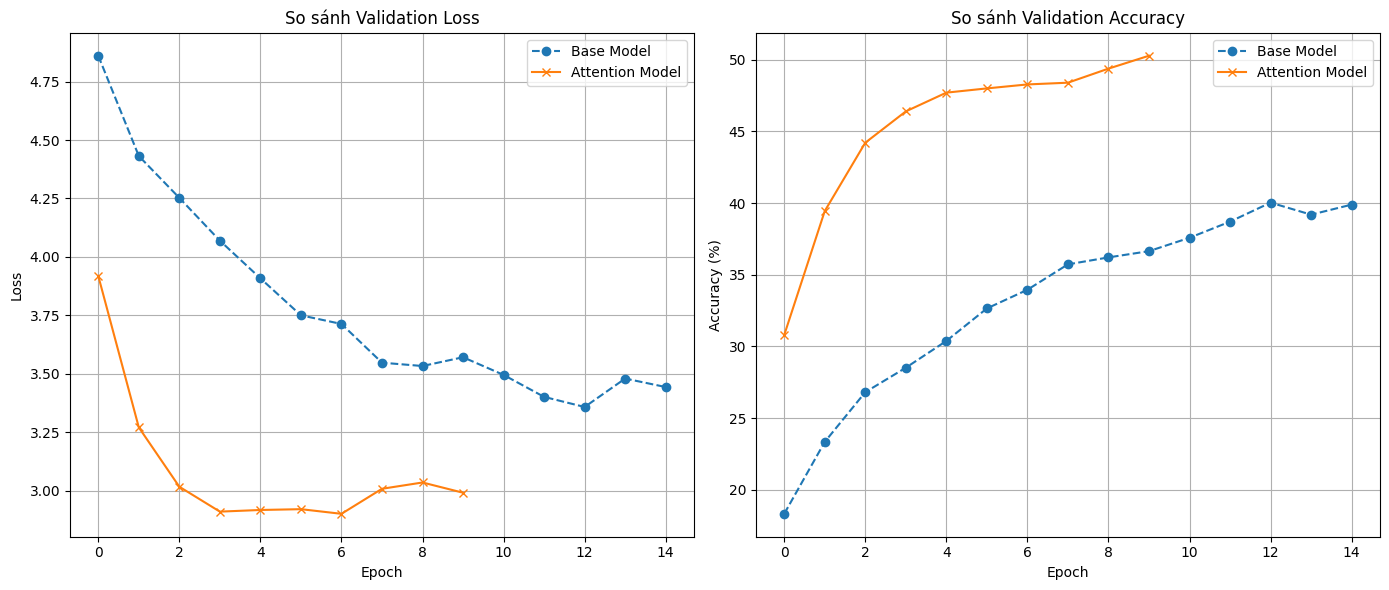


=== BẢNG TỔNG HỢP KẾT QUẢ HUẤN LUYỆN ===


,Model,Best Val Loss,Best Val Acc,Epoch đạt được
0,Base Seq2Seq,3.3585,40.03%,13
1,Attention Seq2Seq,2.9016,48.28%,7


In [24]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import os
from IPython.display import display

# ==========================================
# SO SÁNH HAI MÔ HÌNH
# ==========================================
base_history_file = 'models/training_history.json'
attn_history_file = 'models/history_attn.json'

data = []

# 1. Load dữ liệu
if os.path.exists(base_history_file) and os.path.exists(attn_history_file):
    with open(base_history_file, 'r') as f: base_hist = json.load(f)
    with open(attn_history_file, 'r') as f: attn_hist = json.load(f)
    
    # 2. Vẽ biểu đồ so sánh
    plt.figure(figsize=(14, 6))
    
    # --- Biểu đồ Validation Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(base_hist['val_loss'], label='Base Model', linestyle='--', marker='o')
    plt.plot(attn_hist['val_loss'], label='Attention Model', linestyle='-', marker='x')
    plt.title('So sánh Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- Biểu đồ Validation Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot([x*100 for x in base_hist['val_acc']], label='Base Model', linestyle='--', marker='o')
    plt.plot([x*100 for x in attn_hist['val_acc']], label='Attention Model', linestyle='-', marker='x')
    plt.title('So sánh Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('models/comparison_chart.png')
    plt.show()
    
    # 3. Bảng tổng hợp chỉ số tốt nhất
    # Tìm epoch có Val Loss thấp nhất
    best_base_idx = base_hist['val_loss'].index(min(base_hist['val_loss']))
    best_attn_idx = attn_hist['val_loss'].index(min(attn_hist['val_loss']))
    
    data.append({
        'Model': 'Base Seq2Seq',
        'Best Val Loss': f"{base_hist['val_loss'][best_base_idx]:.4f}",
        'Best Val Acc': f"{base_hist['val_acc'][best_base_idx]*100:.2f}%",
        'Epoch đạt được': best_base_idx + 1
    })
    
    data.append({
        'Model': 'Attention Seq2Seq',
        'Best Val Loss': f"{attn_hist['val_loss'][best_attn_idx]:.4f}",
        'Best Val Acc': f"{attn_hist['val_acc'][best_attn_idx]*100:.2f}%",
        'Epoch đạt được': best_attn_idx + 1
    })
    
    print("\n=== BẢNG TỔNG HỢP KẾT QUẢ HUẤN LUYỆN ===")
    df = pd.DataFrame(data)
    
    display(df.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))

else:
    print("Không tìm thấy đủ file lịch sử huấn luyện để so sánh.")